In [1]:
from utils import load_caption, load_vocab, decode_caption, load_annotations, print_image
from nltk.translate import bleu_score

import pickle
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.style.use('ggplot')

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
vocab = load_vocab('/home/spb61/coco2014_vocab.json')
image_id_to_index, index_to_image_id, annotations_dict = load_annotations(annotations_dir='/home/spb61/annotations',
                                                                          annotations_file='captions_val2014.json',
                                                                          map_file = '/home/spb61/val_image_id_to_idx.csv')

idx_to_word
word_to_idx
Loaded dictionary...
Dictionary size: 5004
Error proccessing image_id: image_index
Skipping file person_keypoints_train2014.json
Skipping file instances_train2014.json


In [3]:
def get_vote_caption(image_id, voted_pickle_file='../outputs/vote_captions_100_unigram_overlap.pickle'):
    with open(voted_pickle_file, 'rb') as handle:
        voted_captions = pickle.load(handle)
    caption_object = voted_captions[image_id]
    return caption_object[0][0]

In [4]:
def find_vote_index(beam_captions, image_id, voted_pickle_file='../outputs/vote_captions_100_unigram_overlap.pickle'):
    vote_caption = get_vote_caption(image_id, voted_pickle_file)
    for i, cap in enumerate(beam_captions):
        if np.array_equal(cap['sentence'], vote_caption):
            return i
    raise ValueError("Could not find corresponding beam")

In [5]:
def get_annotations(image_id):
    return [' '.join(cap) for cap in annotations_dict[image_id]]

[36290, 10622, 6660, 33297, 33626, 20514, 38585, 33347, 38586, 28086]
37
12
77
69
95
31
91
80
16
30


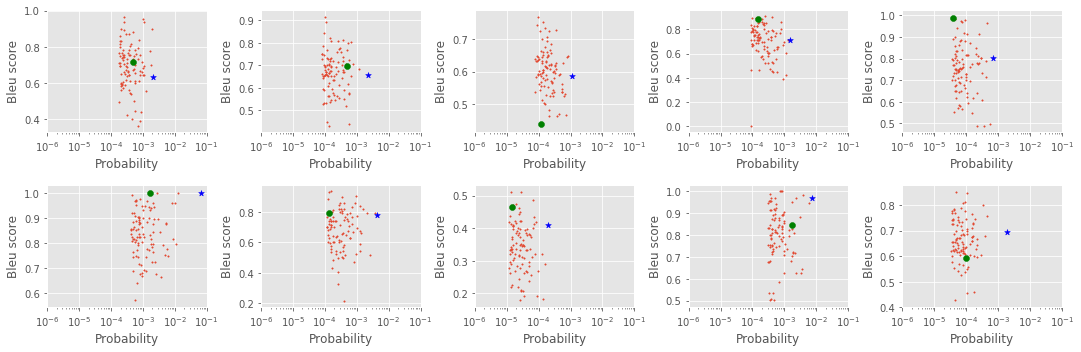

In [6]:
fig = plt.figure(figsize=(15, 5))
# image_ids = np.random.choice(40000, size=10, replace=False)
image_ids = [36290, 10622, 6660, 33297, 33626, 20514, 38585, 33347, 38586, 28086]
print(image_ids)
for i, image_id in enumerate(image_ids):
    axes = fig.add_subplot(2, 5, i+1)
    image_id = int(image_id)
    beam_size = 100
    image_dir = "/datadrive/val_beam_{}_states/".format(beam_size)   
    caption_object = load_caption(image_id, image_dir=image_dir)['captions']
    probabilities = np.array([c['score'] for c in caption_object])
#     print(probabilities * 100)
    annotations = get_annotations(image_id)
    bleu_scores = []
    for j, cap in enumerate(caption_object):
        sentence = ' '.join(decode_caption(cap['sentence'], vocab))
    #     print(sentence)
        bleu_scores.append(bleu_score.sentence_bleu(annotations, sentence))
    axes.scatter(probabilities, bleu_scores, s=2)
    axes.scatter(probabilities[0], bleu_scores[0], marker='*', color='blue')
    
    vote_index = find_vote_index(caption_object, image_id)
    print(vote_index)
    axes.scatter(probabilities[vote_index], bleu_scores[vote_index], marker='o', color='green')

    axes.set_xscale('log')
    axes.set_xlim([1e-6, 0.1])
    axes.set_xlabel("Probability")
    axes.set_ylabel("Bleu score")
plt.tight_layout()
# plt.savefig('../outputs/figs/sentence_beam_bleu.png', bbox_inches='tight')

In [7]:
# Beam bleus
beams = pickle.load(open('/datadrive/beams_{}.pickle'.format(10), 'rb'))
print(len(beams))
for i in range(100):
    beam_cap = ' '.join(decode_caption(beams[i][0]['sentence'], vocab))
    print(beam_cap)

40504
a man riding a skateboard up the side of a ramp
a bowl of soup sitting on a table
a bus that is sitting in the street
a motorcycle parked on the side of a road
a laptop computer sitting on top of a wooden desk
a black and white photo of a person on a skateboard
a little boy that is eating some food
a man standing in a forest holding a frisbee
a group of people walking down a street
a group of people standing in front of a bus
a close up of a dog in a cage
a pile of luggage sitting on top of a floor
a batter catcher and umpire during a baseball game
a close up of a street sign with a sky background
a group of people sitting around a table
a fire hydrant sitting on the side of a road
a group of people standing around a table
a city street filled with lots of traffic
a man riding skis down a snow covered slope
a group of children sitting at a table eating food
a hands train that is pulling into a station
a cat laying on top of a laptop computer
a clock tower in the middle of a city


In [8]:
beams = {}
for k in [1,2,10,100]:
    beams[k] = pickle.load(open('/datadrive/beams_{}.pickle'.format(k), 'rb'))
    
beam_bleus = {}
image_ids = sorted(beams[1].keys())
print(len(image_ids))
for k in [1,2,10,100]:
    annotations = []
    generated_caps = []
    bleus = []
    for image_id in tqdm(image_ids):
        beam_captions = beams[k][image_id]
        beam_cap = decode_caption(beam_captions[0]['sentence'], vocab)
        annotations_caps = annotations_dict[image_id]
        bleu = bleu_score.sentence_bleu(annotations_caps, beam_cap, weights=[0.25, 0.25, 0.25, 0.25])
        bleus.append(bleu)
    beam_bleus[k] = bleus

  0%|          | 0/40504 [00:00<?, ?it/s]/anaconda/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/anaconda/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/anaconda/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  1%|          | 264/40504 [00:00<00:15, 2635.25it/s]

40504


100%|██████████| 40504/40504 [00:15<00:00, 2559.87it/s]


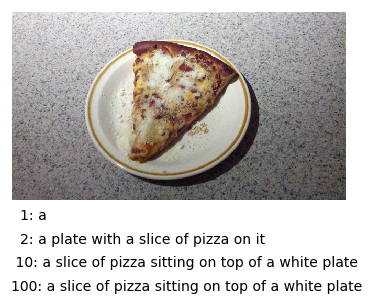

In [103]:
image_id = image_ids[np.argmax(np.array(beam_bleus[100]) - np.array(beam_bleus[1]))]

print_image(image_id, image_dir='/home/spb61/val_2014/')
plt.xticks([])
plt.yticks([])
for i, k in enumerate([1,2,10,100]):
    plt.text(0, 400 + i * 45, "{:3d}: {}".format(k, ' '.join(decode_caption(beams[k][image_id][0]['sentence'], vocab))), fontsize=14)
plt.savefig("../outputs/figs/example_image_large_beam1.png", bbox_inches='tight')

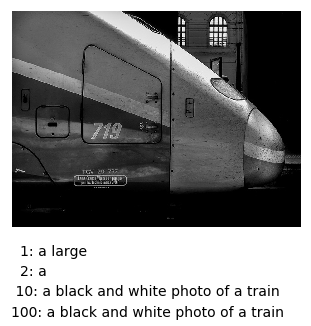

In [84]:
image_id = image_ids[np.argsort(np.array(beam_bleus[100]) - np.array(beam_bleus[2]))[-5]]

print_image(image_id, image_dir='/home/spb61/val_2014/')
plt.xticks([])
plt.yticks([])
for i, k in enumerate([1,2,10,100]):
    plt.text(0, 540 + i * 45, "{:3d}: {}".format(k, ' '.join(decode_caption(beams[k][image_id][0]['sentence'], vocab)), fontsize=0), fontsize=14)
plt.savefig("../outputs/figs/example_image_large_beam2.png", bbox_inches='tight')

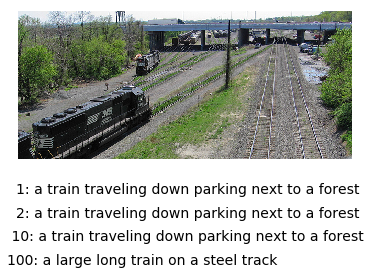

In [102]:
image_id = image_ids[np.argsort(np.array(beam_bleus[100]) - np.array(beam_bleus[10]))[-3]]

print_image(image_id, image_dir='/home/spb61/val_2014/')
plt.xticks([])
plt.yticks([])
for i, k in enumerate([1,2,10,100]):
    plt.text(-20, 350 + i * 45, "{:3d}: {}".format(k, ' '.join(decode_caption(beams[k][image_id][0]['sentence'], vocab))), fontsize=14)
plt.savefig("../outputs/figs/example_image_large_beam3.png", bbox_inches='tight')

# Position ranks analysis

In [ ]:
beams_10 = pickle.load(open('/datadrive/beams_10.pickle', 'rb'))
positions = []
for image_id, caption_object in tqdm(beams_10.items()):
    positions.append(find_vote_index(caption_object, image_id, voted_pickle_file='../outputs/vote_captions_10_unigram_overlap.pickle'))

 12%|█▏        | 4716/40504 [18:28<2:20:10,  4.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 8013/40504 [30:30<2:03:40,  4.38it/s]

In [13]:
beams_10[0]
np.mean(positions)

3.7359273158206596